### And welcome to Week 4, Day 3 - more LangGraph..

In [31]:
from typing import Annotated, TypedDict
import os
import requests
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI
import gradio as gr
from IPython.display import Image, display
from dotenv import load_dotenv

In [2]:
# 🔑 API setup
os.environ["OPENAI_API_KEY"] = os.getenv('ROUTER_API_KEY')
os.environ["OPENAI_API_BASE"] = "https://openrouter.ai/api/v1"

In [3]:
llm = ChatOpenAI(
    model="mistralai/mixtral-8x7b-instruct",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("ROUTER_API_KEY"),
)

In [4]:
user_input = "What am I doing of my life?"

In [5]:
message = [{"role": "user", "content": user_input}]

In [6]:
result = llm.invoke(message)

In [7]:
print(result.content)

 I'm just a computer program and I don't have a life. But I can help you reflect on how you are spending your time. Here are some questions you can ask yourself:

* Am I engaging in activities that bring me joy and fulfillment?
* Am I making progress towards my goals and aspirations?
* Am I investing in my relationships and building connections with others?
* Am I taking care of my physical and mental health?
* Am I learning and growing as a person?

If you are unhappy with how you are spending your time, you may want to consider making some changes. This could include setting new goals, pursuing new hobbies or interests, or making an effort to connect with others. Remember, it's never too late to make a positive change in your life.


In [8]:
# Our favorite first step! Crew was doing this for us, by the way.
load_dotenv(override=True)


False

### First, let's go set up LangSmith!

https://langsmith.com

### Next, here is a useful function in LangChain community:

In [9]:
from langchain_community.utilities import GoogleSerperAPIWrapper

In [10]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("What is the capital of France?")

"Paris is the capital and largest city of France. With an estimated population of 2,048,472 residents in January 2025 in an area of more than 105 km2 (41 sq ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world's most ... The capital of France has been Paris since its liberation in 1944. NARRATOR: The Eiffel Tower is the best-known symbol of Paris, the capital of France. Paris is an important center for business and culture. With its wide ... Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage .

### Now here is a LangChain wrapper class for converting functions into Tools

In [11]:
from langchain.agents import Tool

In [12]:
tool_search = Tool(
    name="search",
    func=serper.run,
    description="Useful for when you need more information from an online search"
)

### Now we can try out the tool the langchain way

In [13]:
tool_search.invoke("What is the capital of Sao Paulo?")

'São Paulo is the capital of the state of São Paulo, as well as the most populous city in Brazil, the Americas, and both the Western and Southern Hemispheres ... São Paulo, city, capital of São Paulo estado (state), southeastern Brazil. It is the foremost industrial centre in Latin America. Its capital is the municipality of São Paulo. São Paulo. State · Flag of São Paulo. Flag · Coat of arms of São Paulo. Coat of arms. Motto(s):. Pro Brasilia ... São Paulo, or Sampa as it is also called, is the largest city in Brazil, with a municipality population of 12.1 million, and about 21.3 million in its ... The name means Saint Paul; it is the capital of the State of Sao Paulo, the most populous Brazilian state. The city is the largest city in Brazil. The city of Sao Paulo is the capital of the state of the same name. It was founded and named by the Portuguese, and its name means "St. Paul". São Paulo, City (pop., 2021 est.: city, 12,284,940; Greater São Paulo, 22,048,504), capital of São Paul

### And now let's write a tool ourselves

We'll pick a familiar one

In [14]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

In [19]:
def push(text:str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

In [20]:
tool_push = Tool(
    name = "send_push_notification",
    func=push,
    description="useful tool wrap to send push notification. not ds"
)

In [21]:
tool_push.invoke("Bla Bla")

### Back to the Graph from yesterday

One small change - using TypedDict instead of BaseModel for the State object

When we implement tools, we always need to make 2 changes to the code:

1. Changes to provide the tools to OpenAI in json when we make the call

2. Changes to handle the results back: look for the model staying that the finish_reason=="tool_calls" and then retrieve the call, run the function, provide the results.

### Bring them together

In [29]:
# list of tools
tools = [tool_search, tool_push]

In [24]:
# Step 1: Define the State object
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [39]:
# Step 2: Start eh Graph Builder with the State class
graph_builder = StateGraph(State)

In [40]:
# This is different:
llm = ChatOpenAI(
    model="mistralai/mixtral-8x7b-instruct",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("ROUTER_API_KEY"),
)

In [41]:
llm_with_tools = llm.bind_tools(tools)

In [42]:
# Step 3: Create a Node
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [43]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [44]:
# Step 4: Create Edges
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")

In [45]:
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

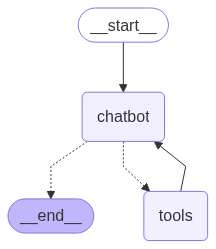

In [46]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! And, let's do this:

In [47]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    print(result)
    return result["messages"][-1].content

In [48]:
gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='what am I doing?', additional_kwargs={}, response_metadata={}, id='2c68826e-b28b-458e-9ab2-359cd07307bf'), AIMessage(content=' You are interacting with a language model, which is a type of artificial intelligence that can understand and generate human-like text. I can provide responses to a wide range of prompts, such as answering questions, providing explanations, and even carrying on a conversation.\n\nIn this specific instance, you are attempting to retrieve information about the available tools in this environment. These tools are functions that you can call to perform specific tasks, such as searching for information online or sending push notifications.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 182, 'total_tokens': 282, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'mistralai/mixtral-8x7b-instruct', 'system_fingerprint': None, 'id': 'ge

## OK it's time to add Memory!

### BUT WAIT!

We have this whole Graph maintaining the state and appending to the state.

Why isn't this handling memory?

### This is a crucial point for understanding LangGraph

> A super-step can be considered a single iteration over the graph nodes. Nodes that run in parallel are part of the same super-step, while nodes that run sequentially belong to separate super-steps.


One "Super-Step" of the graph represents one invocation of passing messages between agents.

In idomatic LangGraph, you call invoke to run your graph for each super-step; for each interaction.

The reducer handles state updates automatically within one super-step, but not between them.

That is what checkpointing achieves.

In [34]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [ ]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

In [ ]:
graph.get_state(config)

In [ ]:
# Most recent first

list(graph.get_state_history(config))

### LangGraph gives you tools to set the state back to a prior point in time, to branch off:

```
config = {"configurable": {"thread_id": "1", "checkpoint_id": ...}}
graph.invoke(None, config=config)
```

And this allows you to build stable systems that can be recovered and rerun from any prior checkpoint.

### And now let's store in SQL

### And this is the power of LangGraph.

In [10]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

In [ ]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))
 

In [ ]:
config = {"configurable": {"thread_id": "3"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()